<table style="width:100%">
  <tr style="background-color:#002147">
    <th><p style="color:white">Professional Programme, Department of Computer Science, University of Oxford</th> 
  </tr>
</table>

# Things of the Internet (TOI) - Lab 4: Cloud or Edge


###  Introduction

In the Industrial IOT, monitoring the behaviour of machines (in particular motors) is of key importance for predictive maintenance. In this lab, we will investigate the relative merits of processing data on the cloud compared with on-device (edge), and the relative impacts in terms of communication load and energy consumption.

As an example, consider monitoring irrigation pumps on a smart farm to enable precision agriculture. Knowing that a pump has failed or has an issue is key to improving efficiency. Ideally, given sufficient training data, it may even be possible to detect a failure before it even happens.

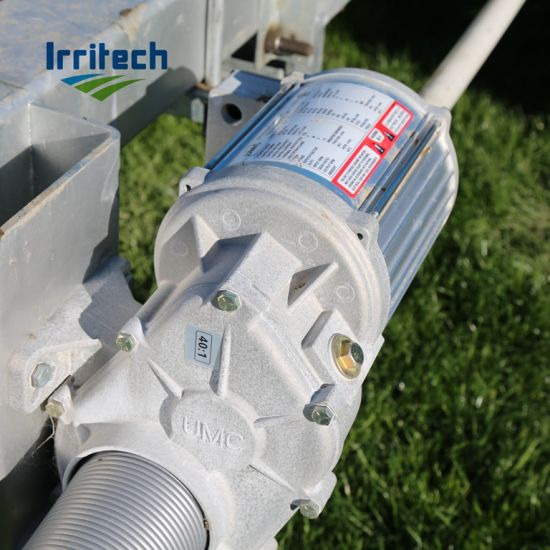

### 1 Vibration Sensing: A Primer
A simple way of measuring the behaviour of a machine is to assess its levels of vibration. We can build a model of the machine (a so-called digital twin) and determine whether levels of vibration are within bounds or excessively high. The performance of the detection algorithm is what sets apart techniques.

There are many ways of measuring vibration such as using a microphone (acoustic condition monitoring) or using an accelerometer. In this lab, we will consider the latter, but the techniques described here are generic enough to be used for different types of signals.

We have been supplied with some sample datasets [trainA.csv] and [testA.csv]. Use a text-editor to open one and examine the contents. Each line consists of a label (0,1 or 2) and 100 samples (corresponding to 1 second of data). The label represents the operating conditions:

- 0: NORMAL: normal
- 1: FAULT: an issue with the motor
- 2: ERROR: an issue with the sensor e.g. it is not properly attached to the motor assembly

Our goal is to try and develop some algorithms that can analyse this data, so we can identify failing motors. We can then deploy our product and start printing money.

Run the code snippet below to build the training dataset

In [4]:
import csv
import numpy
f = open('trainA.csv')
reader = csv.reader(f)
train_labels = []
train_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        train_labels.append(label)
        train_dataset.append(data)
f.close()

f = open('testA.csv')
reader = csv.reader(f)
test_labels = []
test_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        test_labels.append(label)
        test_dataset.append(data)
f.close()

**Task 1.1**: Use matplotlib to plot sample data for a sample of each condition (NORMAL, FAULT, ERROR).

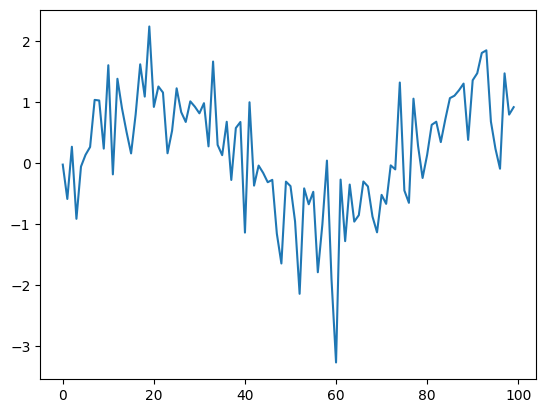

In [18]:
import matplotlib.pyplot as plt

plt.plot(data)
plt.show()

**Question 1.2**: Can you visually tell them apart?

Your answer:

### 2 Cloud-based Classifier

We start first with the typical approach to IoT deployments: all data will be sent to the cloud, where it will be analysed with state-of-the-art machine learning algorithms. This allows us to get the maximum value out of the data, and provide analytics about device behaviour.

We are going to use a black-box machine learning classifier: a Random Forest. This is often termed the "swiss-army" knife of classifiers, as it uses an ensemble of decision trees to learn relationships between data. We don't need to understand the details of how it works, we just use it as a black-box.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a random forest classifier
clf=RandomForestClassifier(n_estimators=100,random_state=101)
# Train the model
clf.fit(train_dataset,train_labels)
# Test how well it works
y_pred=clf.predict(test_dataset)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.993



**Question 2.1**: Comment on the accuracy that you achieve. What are the implications of any inaccuracies? Do you think it is sufficient for the application setting?

Your answer:

The sensor node is connected to a central IoT gateway, using a long-range narrowband transceiver (LORA).

Assume that the sensor takes 100 samples every second i.e. one row in your dataset. This consumes 1 unit of energy. Computation takes a further 2 units of energy. Transmission takes 0.03 units of energy per byte sent. Assume each sample is represented as a 32 bit float.

**Question 2.2**: What is the energy consumed per second for this setting?

Your answer:

Assume that the sensor is equipped with a battery with a capacity of 100M units of energy.

<br/>

**Question 2.3**: How many days will the device last before the battery is exhausted?

Your answer:

**Question 2.4**: What simple techniques could you use to reduce the amount of energy consumed?

Your answer:


**Question 2.5**: (Advanced, optional) Implement your technique and using the black box random forest predictor above, check to see the impact on accuracy. What is the impact on your overall system lifetime?

Your answer:

The random forest has 100 estimators, each of which is a decision tree. The total number of parameters to store the tree depends on the depth and breadth of the tree which is randomly constructed, but typically there are about ~20k parameters in this black box, with a model size of 80 kbyte. This is quite a small model to run on the cloud, but is a significant cost to run every second on an end node, if it's even possible.

### 3 Edge based classifier

Rather than pushing all the data to the cloud, we are going to explore the tradeoffs surrounding processing the data on the device itself. Clearly, running a black-box classifier like a random forest is very expensive on the device, so your job is to design a more computationally efficient approach.

To design your own classifier, you can consider extracting some statistical features like the mean, the min/max, the standard deviation etc. The code below might help you get started.

In [ ]:
mean = numpy.mean(data)
median = numpy.median(data)
max = numpy.max(data)
min = numpy.min(data)
standard_deviation = numpy.std(data)

**Question 3.3**: Design a classifier that returns a class label (e.g. 0, 1 or 2) when given a sample. What is the accuracy of your classifier?

Your answer:

Rather than time-domain statistical operations, it often helps to transform the data to the frequency domain, to extract the signals in each frequency band. A common and computationally efficient technique for this is to use the Fast Fourier Transform. This converts the time series to the frequency domain. By transforming to a different domain, it is often easier to design a simpler classifier.

The following code plots the FFT magnitude for the first 10 samples in the training dataset. Can you visually see some difference between the classes? Please do not forget to reload the train and test dataset if you have altered the dataset in previous questions.

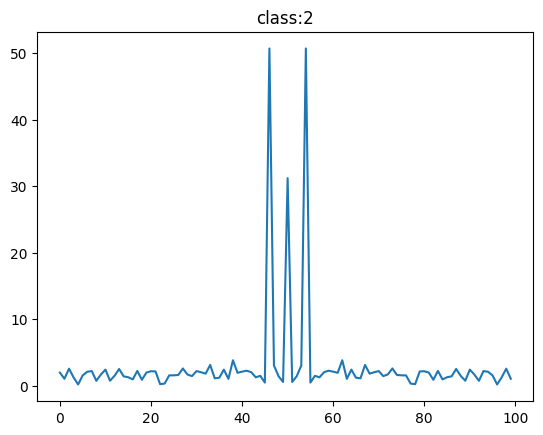

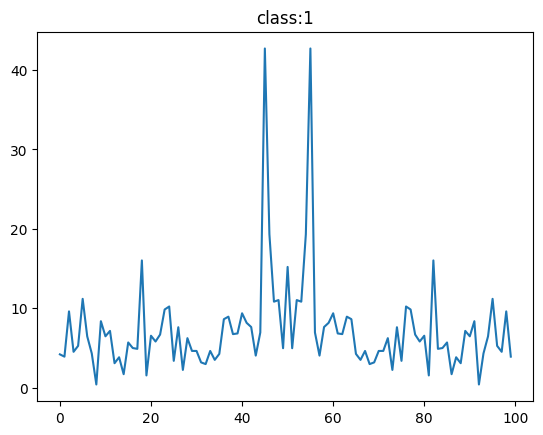

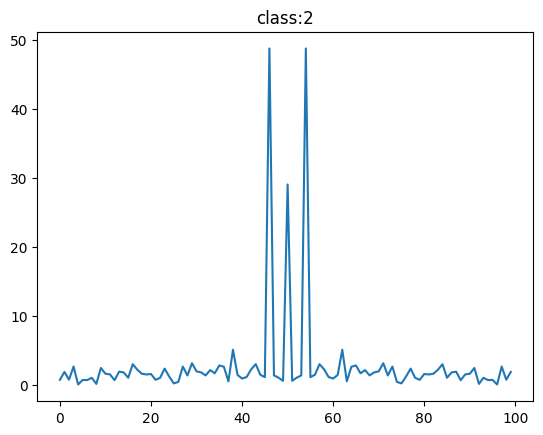

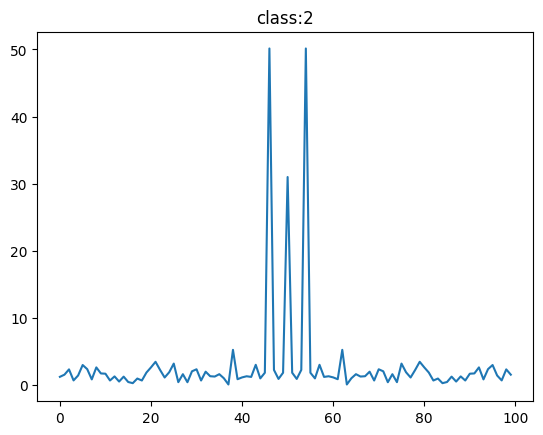

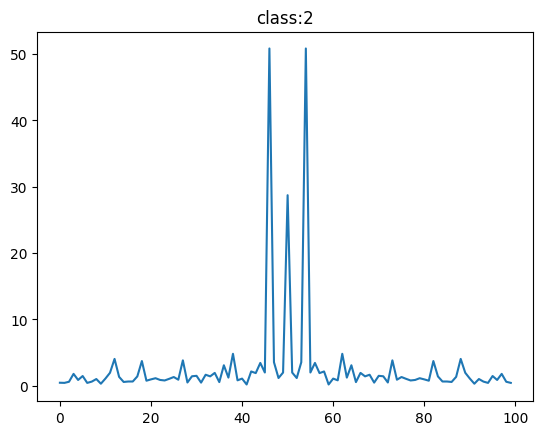

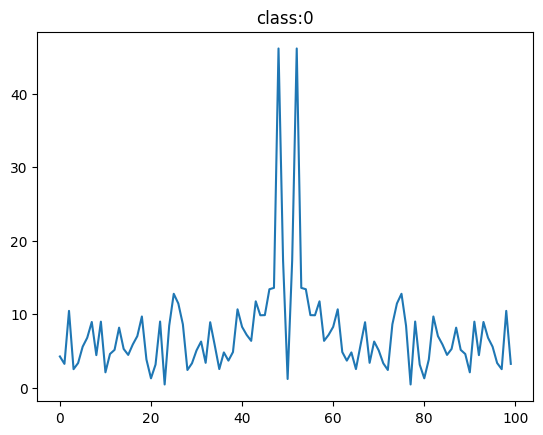

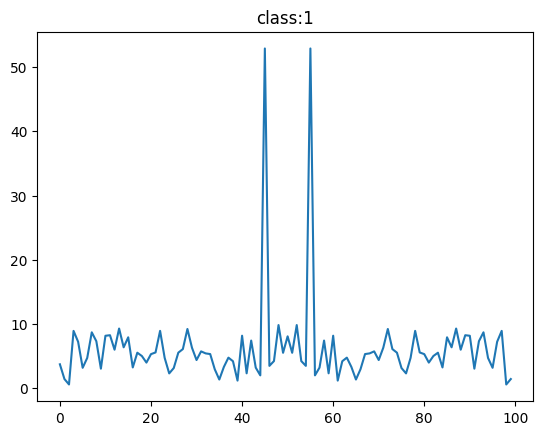

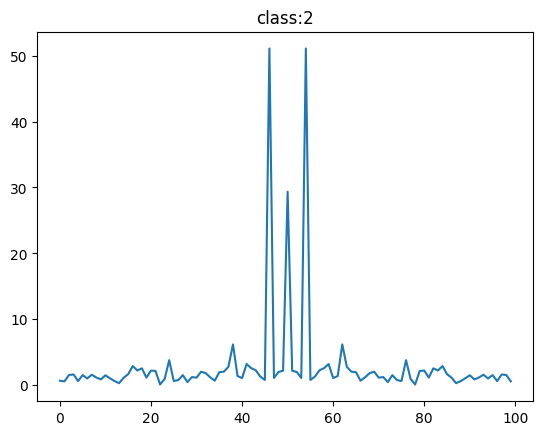

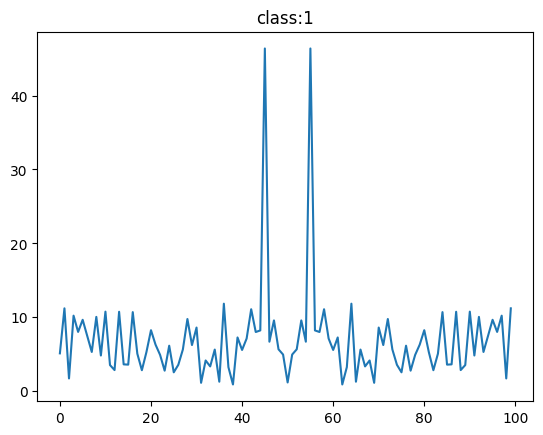

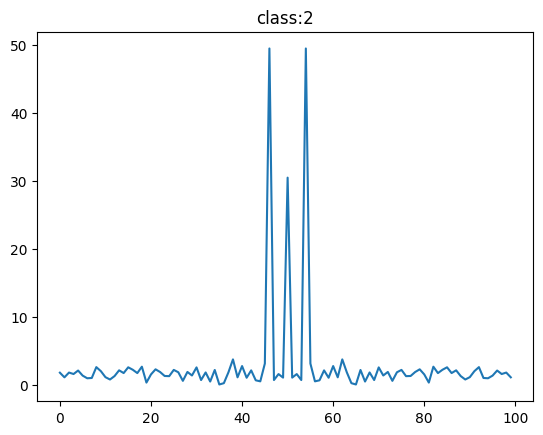

In [16]:
import matplotlib.pyplot as plt
for k in range(10):
    data = train_dataset[k]
    label = train_labels[k]
    features = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    plt.plot(features)
    plt.title("class:"+str(label))
    plt.show()

**Question 3.4**: Design a classifier that returns a class label (e.g. 0, 1 or 2) when given a sample. What is the accuracy of your classifier? Do you think that this accuracy is sufficient for the application at hand?

Your answer:

**Question 3.5**: Using the same assumptions as above, what is the device lifetime using the edge based classifier?

Your answer:

### 4 Hybrid based approach

The testing dataset that you have used (TestA.csv) is balanced i.e. there are equal numbers of each sample (NORMAL, FAULT, ERROR).

<br/>

**Question 4.1**: Do you think this is the reality for detecting condition based anomalies?


Your answer:

Dataset B more closely reflects real data. Use the following code snippet to load it:

In [17]:
f = open('testB.csv')
reader = csv.reader(f)
real_labels = []
real_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        real_labels.append(label)
        real_dataset.append(data)
f.close()

**Question 4.2**: What is the ratio between the class labels?

Your answer:

With your FFT based classifer, consider whether you can achieve a higher accuracy if you lump together the fault/error labels into one category i.e. you simply need to decide whether the data is NORMAL or not.

**Question 4.3**: What is your accuracy if you simply detect **any** anomalous data?

Your answer:

Use your device based FFT classifier to detect any anomalous data. If anomalous data is detected, send the raw data (100 samples) to your random forest based classifier. 

**Question 4.4**: What is your overall system accuracy?

Your answer:

**Question 4.5**: What is the impact on your system lifetime using this approach

Your answer:

### 5 Mesh based communication

Instead of using LORA which consumes 0.03 units of energy per byte, you instead opt to use a low power radio which only uses 0.005 units of energy per byte. However, it is impossible to reach the gateway from all locations, and the data has to 'hop' over multiple nodes. Use a simple tree to forward the data to the gateway.

Assume that each node has N=2 children and so forth. Each node is responsible for sending its own traffic, as well as any data from its children.


**Question 5.1**: How does the amount of traffic grow with increasing depth D, assuming nodes are sending raw data (100 bytes of 32 bit float)?


Your answer:

**Question 5.2**: At what depth D is the long range radio approach more energy efficient than the mesh approach?

Your answer:

**Question 5.3**: How does altering the number of children N impact the traffic growth?

Your answer:

**Question 5.4**: (optional) One approach to increasing sensor fault tolerance is to use multiple sensors per motor. Assuming that sensor faults are uncorrelated, how would this impact overall accuracy? Would you have advantages in processing the data locally versus sending both sets of raw data to the cloud?

Your answer: